# Year 2

## Importing modules

In [1]:
#standard libs
from math import sqrt
import random
import os

#default data science libs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#modules for data preprocessing
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve, KFold
from sklearn.model_selection import RandomizedSearchCV

#classification models
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb

#evaluation metrics
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsClassifier




In [2]:
from scipy.io import arff

## loading data

In [3]:
data = pd.read_excel('data/2year.xlsx')
data['B'] = (data['B'].index > 9772).astype(int)

In [4]:
data.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X56,X57,X58,X59,X60,X61,X62,X63,X64,B
0,0.202350,0.46500,0.240380,1.5171,-14.547,0.510690,0.25366,0.91816,1.15190,0.42695,...,0.13184,0.473950,0.86816,0.00024,8.5487,5.16550,107.740,3.38790,5.3440,0
1,0.030073,0.59563,0.186680,1.3382,-37.859,-0.000319,0.04167,0.67890,0.32356,0.40437,...,0.12146,0.074369,0.87235,0.00000,1.5264,0.63305,622.660,0.58619,1.2381,0
2,0.257860,0.29949,0.665190,3.2211,71.799,0.000000,0.31877,2.33200,1.67620,0.69841,...,0.16499,0.369210,0.81614,0.00000,4.3325,3.19850,65.215,5.59690,47.4660,0
3,0.227160,0.67850,0.042784,1.0828,-88.212,0.000000,0.28505,0.47384,1.32410,0.32150,...,0.29358,0.706570,0.78617,0.48456,5.2309,5.06750,142.460,2.56210,3.0066,0
4,0.085443,0.38039,0.359230,1.9444,21.731,0.187900,0.10823,1.37140,1.11260,0.52167,...,0.10124,0.163790,0.89876,0.00000,5.7035,4.00200,89.058,4.09840,5.9874,0


# Data preprocessing

In [5]:
def set_new_headers(df):
    cols = ['X' + str(i+1) for i in range(len(df.columns)-1)]
    cols.append('Y')
    df.columns = cols

imputer = SimpleImputer(missing_values = np.nan, strategy='mean')
mean_imputed_df = pd.DataFrame(imputer.fit_transform(data))
set_new_headers(mean_imputed_df)

data_imp = pd.DataFrame()



In [6]:
Y = mean_imputed_df['Y'].values
mean_imputed_df.drop('Y', axis=1, inplace=True)
X = mean_imputed_df.values

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.3, random_state=10)

In [8]:
#cross validation
nfolds = 10
nclass = 2
ntrain = X_train.shape[0]
ntest = X_test.shape[0]

cross_val = StratifiedKFold(nfolds)

# Creating model objects
## Tuning model hyperparameters

# Second level

In [9]:
def show_feature_importance(model, features, model_name):
    plt.figure(figsize=(12,8))
    results=pd.DataFrame({'feature': features, 'importance': model.feature_importances_})
    results=results.sort_values('importance', ascending=False)
    results.head(70)
#     results.head(20).plot(x = 'feature', y = 'importance', kind = 'barh',
#                      color = 'red', edgecolor = 'k', title = 'Feature Importances of ' + model_name)
    return results

In [10]:
ntrain=X_train.shape[0]
ntest = X_test.shape[0]
nclass = 2
SEED = 42
NFOLDS = 10
print(ntrain, ntest)
kf = KFold(n_splits=NFOLDS, random_state=SEED, shuffle=True)
labels = ['Normal','Bankruptcy']

7121 3052


In [11]:
def BuildModel(best_alg, X_train, y_train, X_test, kf, ntrain, ntest, nclass, NfOLDS):
    Xr_train = np.zeros((ntrain, nclass))
    Xr_test = np.zeros((ntest, nclass))
    tr_ind = np.arange(ntrain)
    smote = SMOTE(sampling_strategy = 0.08, random_state=32)
    for i, (ttrain, ttest) in enumerate(kf.split(tr_ind)):
        clf = best_alg
        X=X_train[ttrain]
        y=y_train[ttrain]
        X_train_sm, y_train_sm= smote.fit_sample(X, y)
        clf.fit(X_train_sm, y_train_sm)
        sc = clf.score(X_train[ttest], y_train[ttest])
        print(i, 'accuracy', sc)
        Xr_train[ttest] = clf.predict_proba(X_train[ttest])
        Xr_test += clf.predict_proba(X_test)/NFOLDS
    
    return Xr_train, Xr_test


def BuildModelNot(best_alg, X_train, y_train, X_test, kf, ntrain, ntest, nclass, NfOLDS):
    Xr_train = np.zeros((ntrain, nclass))
    Xr_test = np.zeros((ntest, nclass))
    tr_ind = np.arange(ntrain)
    smote = SMOTE(sampling_strategy= 0.08, random_state=32)
    for i, (ttrain, ttest) in enumerate(kf.split(tr_ind)):
        clf = best_alg
        X=X_train[ttrain]
        y=y_train[ttrain]
        X_train_sm, y_train_sm= smote.fit_sample(X, y)
        clf.fit(X_train_sm, y_train_sm)
        sc = clf.score(X_train[test], y_train[ttest])
        print(i, 'accuracy', sc)
        Xr_train[ttest] = clf.predict_proba(X_train[ttest])
        Xr_test += clf.predict_proba(X_test, validate_features=False)/NFOLDS
    
    return Xr_train, Xr_test

In [12]:
def show_accuracy(Xr, y, labels, best, nclass):
    pred=[]
    for x in Xr:
        if x > best:
            pred.append(1)
        else:
            pred.append(0)
    print(classification_report(y,pred, target_names=labels, digits=4))
    print(confusion_matrix(y, pred, labels=range(nclass)))

In [13]:
def show_auc(y_train_set, pred_train_set):
    thresholds = np.linspace(0.01, 0.5, 1000)
    f1_sc = np.array([f1_score(y_train_set, pred_train_set[:,1] > thr) for thr in thresholds])
    plt.figure(figsize=(12,8))
    plt.plot(thresholds, f1_sc, linewidth=4)
    plt.ylabel("F1 score", fontsize=18)
    plt.xlabel("Threshold", fontsize=18)
    
    best_model_f1 = thresholds[f1_sc.argmax()]
    
    return best_model_f1

In [14]:
X_train

array([[ 6.2971e-02,  5.1854e-01,  1.0594e-02, ...,  1.1576e+02,
         3.1531e+00,  1.8254e+00],
       [ 4.4568e-04,  8.7631e-01,  3.5080e-01, ...,  1.1420e+02,
         3.1962e+00,  6.6508e+00],
       [ 1.1732e-01,  3.3079e-01,  5.7334e-01, ...,  2.5183e+01,
         1.4494e+01,  9.3508e+00],
       ...,
       [-5.3670e-01,  7.8497e-02,  2.6824e-01, ...,  2.4876e+01,
         1.4673e+01,  1.1851e+00],
       [ 4.6735e-01,  3.9807e-01,  1.4838e-02, ...,  4.3617e+01,
         8.3683e+00,  2.5717e+00],
       [ 8.3040e-02,  5.4857e-01,  2.4094e-01, ...,  8.4371e+01,
         4.3261e+00,  5.8015e+00]])

## Logistic regression

In [15]:
lr_best = LogisticRegression(C=0.5, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)
pred_train, pred_test=BuildModel(lr_best, X_train, y_train, X_test,kf, ntrain, ntest, nclass, NFOLDS)

C:\Developement\Anaconda\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


0 accuracy 0.9523141654978962


C:\Developement\Anaconda\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


1 accuracy 0.9536516853932584


C:\Developement\Anaconda\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


2 accuracy 0.9676966292134831


C:\Developement\Anaconda\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


3 accuracy 0.9747191011235955


C:\Developement\Anaconda\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


4 accuracy 0.9578651685393258


C:\Developement\Anaconda\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


5 accuracy 0.9466292134831461


C:\Developement\Anaconda\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


6 accuracy 0.9438202247191011


C:\Developement\Anaconda\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


7 accuracy 0.952247191011236


C:\Developement\Anaconda\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


8 accuracy 0.9564606741573034
9 accuracy 0.9564606741573034


C:\Developement\Anaconda\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


0.15704387990762123
0.1088888888888889


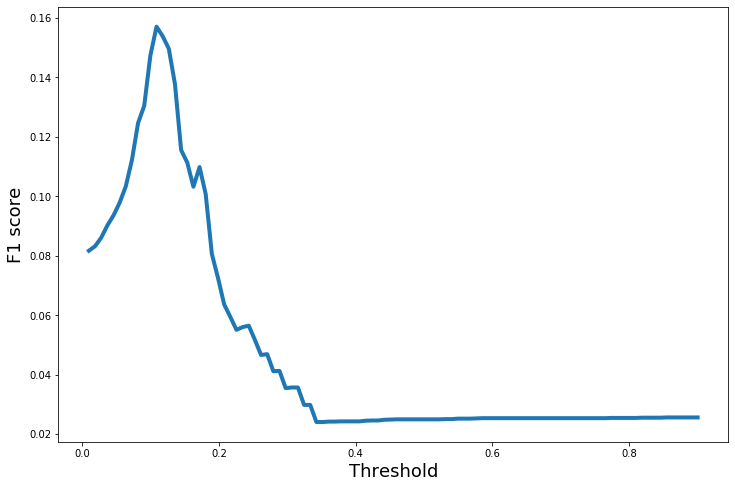

In [16]:
thresholds = np.linspace(0.01, 0.9, 100)
f1_sc = np.array([f1_score(y_train,pred_train[:,1] > thr) for thr in thresholds])
plt.figure(figsize=(12,8))
plt.plot(thresholds, f1_sc, linewidth=4 )
plt.ylabel("F1 score", fontsize=18)
plt.xlabel("Threshold", fontsize=18)
best_lr = thresholds[f1_sc.argmax()]
print(f1_sc.max())
print(best_lr)

In [17]:
show_accuracy(pred_train[:,1],y_train, labels, best_lr, nclass)

              precision    recall  f1-score   support

      Normal     0.9686    0.8677    0.9154      6827
  Bankruptcy     0.1015    0.3469    0.1570       294

    accuracy                         0.8462      7121
   macro avg     0.5350    0.6073    0.5362      7121
weighted avg     0.9328    0.8462    0.8841      7121

[[5924  903]
 [ 192  102]]


In [18]:
show_accuracy(pred_test[:,1],y_test, labels, best_lr, nclass)

              precision    recall  f1-score   support

      Normal     0.9712    0.8714    0.9186      2946
  Bankruptcy     0.0733    0.2830    0.1165       106

    accuracy                         0.8509      3052
   macro avg     0.5223    0.5772    0.5175      3052
weighted avg     0.9401    0.8509    0.8907      3052

[[2567  379]
 [  76   30]]


## Decision tree

In [19]:
dt_best = DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=50,
                       max_features=None, max_leaf_nodes=150,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')
pred_train_dt, pred_test_dt=BuildModel(dt_best, X_train, y_train, X_test,kf, ntrain, ntest, nclass, NFOLDS)

0 accuracy 0.9509116409537167
1 accuracy 0.9353932584269663
2 accuracy 0.9648876404494382
3 accuracy 0.9648876404494382
4 accuracy 0.9480337078651685
5 accuracy 0.9466292134831461
6 accuracy 0.9353932584269663
7 accuracy 0.9508426966292135
8 accuracy 0.9424157303370787
9 accuracy 0.9606741573033708


0.41830065359477125
0.13373737373737374


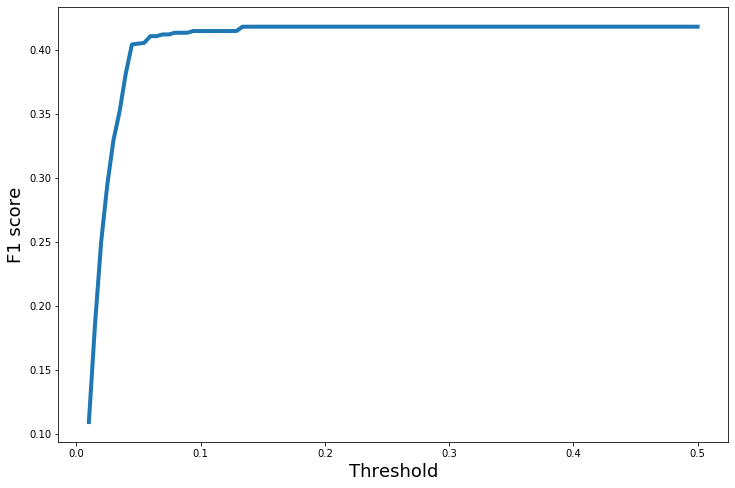

In [20]:
thresholds = np.linspace(0.01, 0.5, 100)
f1_sc_dt = np.array([f1_score(y_train,pred_train_dt[:,1] > thr) for thr in thresholds])
plt.figure(figsize=(12,8))
plt.plot(thresholds, f1_sc_dt, linewidth=4 )
plt.ylabel("F1 score", fontsize=18)
plt.xlabel("Threshold", fontsize=18)
best_dt_f1 = thresholds[f1_sc_dt.argmax()]
print(f1_sc_dt.max())
print(best_dt_f1)

In [21]:
show_accuracy(pred_train_dt[:,1],y_train, labels, best_dt_f1, nclass)

              precision    recall  f1-score   support

      Normal     0.9756    0.9722    0.9739      6827
  Bankruptcy     0.4025    0.4354    0.4183       294

    accuracy                         0.9500      7121
   macro avg     0.6891    0.7038    0.6961      7121
weighted avg     0.9519    0.9500    0.9509      7121

[[6637  190]
 [ 166  128]]


In [22]:
show_accuracy(pred_test_dt[:,1],y_test, labels, best_dt_f1, nclass)

              precision    recall  f1-score   support

      Normal     0.9861    0.9396    0.9623      2946
  Bankruptcy     0.2735    0.6321    0.3818       106

    accuracy                         0.9289      3052
   macro avg     0.6298    0.7858    0.6720      3052
weighted avg     0.9614    0.9289    0.9421      3052

[[2768  178]
 [  39   67]]


In [23]:
print(mean_imputed_df.columns[:-1])

Index(['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10', 'X11',
       'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18', 'X19', 'X20', 'X21',
       'X22', 'X23', 'X24', 'X25', 'X26', 'X27', 'X28', 'X29', 'X30', 'X31',
       'X32', 'X33', 'X34', 'X35', 'X36', 'X37', 'X38', 'X39', 'X40', 'X41',
       'X42', 'X43', 'X44', 'X45', 'X46', 'X47', 'X48', 'X49', 'X50', 'X51',
       'X52', 'X53', 'X54', 'X55', 'X56', 'X57', 'X58', 'X59', 'X60', 'X61',
       'X62', 'X63'],
      dtype='object')


In [24]:
show_feature_importance(dt_best, mean_imputed_df.columns, 'Decision tree')

,feature,importance
33,X34,0.187526
26,X27,0.122278
57,X58,0.075771
55,X56,0.066473
8,X9,0.041355
...,...,...
1,X2,0.000000
27,X28,0.000000
16,X17,0.000000
11,X12,0.000000


<Figure size 864x576 with 0 Axes>

## Random forest

In [25]:
rf_best = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=25, max_features=64, max_leaf_nodes=25,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=150,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

pred_train_rf, pred_test_rf = BuildModel(rf_best, X_train, y_train, X_test,kf, ntrain, ntest, nclass, NFOLDS)

0 accuracy 0.9691444600280504
1 accuracy 0.9648876404494382
2 accuracy 0.9831460674157303
3 accuracy 0.9817415730337079
4 accuracy 0.9691011235955056
5 accuracy 0.9676966292134831
6 accuracy 0.9592696629213483
7 accuracy 0.9676966292134831
8 accuracy 0.9691011235955056
9 accuracy 0.9775280898876404


f1 score of random forest:  0.512035010940919
0.3052525252525253


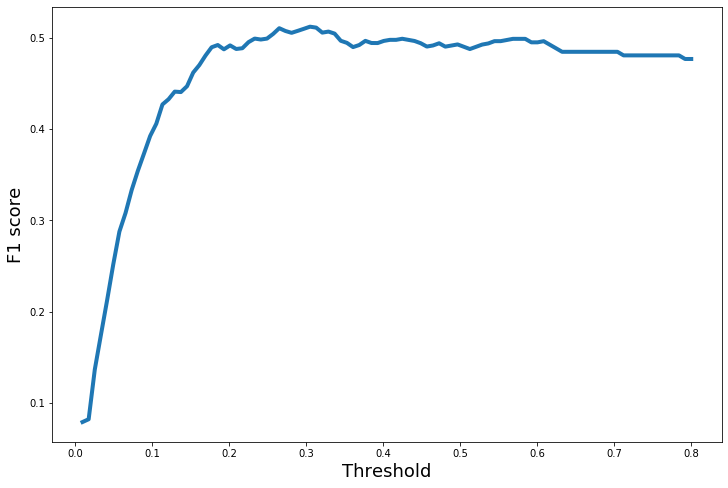

In [26]:
thresholds = np.linspace(0.01, 0.8, 100)
f1_sc_rf = np.array([f1_score(y_train,pred_train_rf[:,1] > thr) for thr in thresholds])
plt.figure(figsize=(12,8))
plt.plot(thresholds, f1_sc_rf, linewidth=4 )
plt.ylabel("F1 score", fontsize=18)
plt.xlabel("Threshold", fontsize=18)
best_rf_f1 = thresholds[f1_sc_rf.argmax()]
print('f1 score of random forest: ', f1_sc_rf.max())
print(best_rf_f1)

In [27]:
show_accuracy(pred_train_rf[:,1],y_train, labels, best_rf_f1, nclass)

              precision    recall  f1-score   support

      Normal     0.9746    0.9933    0.9838      6827
  Bankruptcy     0.7178    0.3980    0.5120       294

    accuracy                         0.9687      7121
   macro avg     0.8462    0.6956    0.7479      7121
weighted avg     0.9640    0.9687    0.9643      7121

[[6781   46]
 [ 177  117]]


In [28]:
show_accuracy(pred_test_rf[:,1],y_test, labels, best_rf_f1, nclass)

              precision    recall  f1-score   support

      Normal     0.9777    0.9966    0.9871      2946
  Bankruptcy     0.7959    0.3679    0.5032       106

    accuracy                         0.9748      3052
   macro avg     0.8868    0.6823    0.7451      3052
weighted avg     0.9714    0.9748    0.9703      3052

[[2936   10]
 [  67   39]]


In [29]:
show_feature_importance(rf_best, mean_imputed_df.columns, 'Random forest')

,feature,importance
33,X34,0.298209
26,X27,0.172555
57,X58,0.085175
55,X56,0.065988
8,X9,0.036962
...,...,...
0,X1,0.001278
6,X7,0.001208
17,X18,0.001176
13,X14,0.000949


<Figure size 864x576 with 0 Axes>

## Xgboost

In [30]:
xgb_best = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eta=5, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logitraw', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

pred_train_xgb, pred_test_xgb = BuildModel(xgb_best, X_train, y_train, X_test, kf, ntrain, ntest, nclass, NFOLDS)

0 accuracy 0.967741935483871
1 accuracy 0.9719101123595506
2 accuracy 0.9831460674157303
3 accuracy 0.9873595505617978
4 accuracy 0.9719101123595506
5 accuracy 0.9691011235955056
6 accuracy 0.9620786516853933
7 accuracy 0.9705056179775281
8 accuracy 0.9705056179775281
9 accuracy 0.9803370786516854


0.5707547169811321


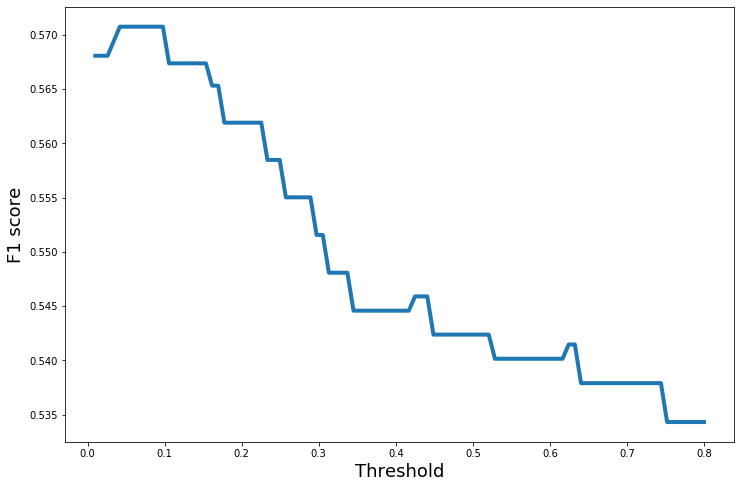

In [31]:
thresholds = np.linspace(0.01, 0.8, 100)
f1_sc_xgb = np.array([f1_score(y_train,pred_train_xgb[:,1] > thr) for thr in thresholds])
plt.figure(figsize=(12,8))
plt.plot(thresholds, f1_sc_xgb, linewidth=4 )
plt.ylabel("F1 score", fontsize=18)
plt.xlabel("Threshold", fontsize=18)
best_thr_xgb = thresholds[f1_sc_xgb.argmax()]
print(f1_sc_xgb.max())

In [32]:
show_accuracy(pred_train_xgb[:,1],y_train, labels, best_thr_xgb, nclass)

              precision    recall  f1-score   support

      Normal     0.9753    0.9987    0.9868      6827
  Bankruptcy     0.9308    0.4116    0.5708       294

    accuracy                         0.9744      7121
   macro avg     0.9530    0.7051    0.7788      7121
weighted avg     0.9734    0.9744    0.9697      7121

[[6818    9]
 [ 173  121]]


In [33]:
show_accuracy(pred_test_xgb[:,1],y_test, labels, best_thr_xgb, nclass)

              precision    recall  f1-score   support

      Normal     0.9784    0.9976    0.9879      2946
  Bankruptcy     0.8542    0.3868    0.5325       106

    accuracy                         0.9764      3052
   macro avg     0.9163    0.6922    0.7602      3052
weighted avg     0.9740    0.9764    0.9721      3052

[[2939    7]
 [  65   41]]


In [34]:
show_feature_importance(xgb_best, mean_imputed_df.columns, 'XGboost')

,feature,importance
33,X34,0.064120
55,X56,0.047987
26,X27,0.035186
8,X9,0.025015
22,X23,0.024301
...,...,...
1,X2,0.008212
31,X32,0.007185
51,X52,0.003490
17,X18,0.000000


<Figure size 864x576 with 0 Axes>

C:\Developement\Anaconda\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Developement\Anaconda\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Developement\Anaconda\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Developement\Anaconda\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


0 accuracy 0.9467040673211781
1 accuracy 0.9564606741573034
2 accuracy 0.9676966292134831


C:\Developement\Anaconda\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Developement\Anaconda\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Developement\Anaconda\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


3 accuracy 0.9719101123595506
4 accuracy 0.9550561797752809
5 accuracy 0.9466292134831461


C:\Developement\Anaconda\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Developement\Anaconda\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Developement\Anaconda\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


6 accuracy 0.9424157303370787
7 accuracy 0.952247191011236
8 accuracy 0.9578651685393258


C:\Developement\Anaconda\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


9 accuracy 0.9508426966292135
0.15124816446402348
              precision    recall  f1-score   support

      Normal     0.9684    0.8586    0.9102      6827
  Bankruptcy     0.0964    0.3503    0.1512       294

    accuracy                         0.8377      7121
   macro avg     0.5324    0.6045    0.5307      7121
weighted avg     0.9324    0.8377    0.8789      7121

[[5862  965]
 [ 191  103]]
              precision    recall  f1-score   support

      Normal     0.9701    0.8466    0.9041      2946
  Bankruptcy     0.0603    0.2736    0.0988       106

    accuracy                         0.8267      3052
   macro avg     0.5152    0.5601    0.5015      3052
weighted avg     0.9385    0.8267    0.8761      3052

[[2494  452]
 [  77   29]]


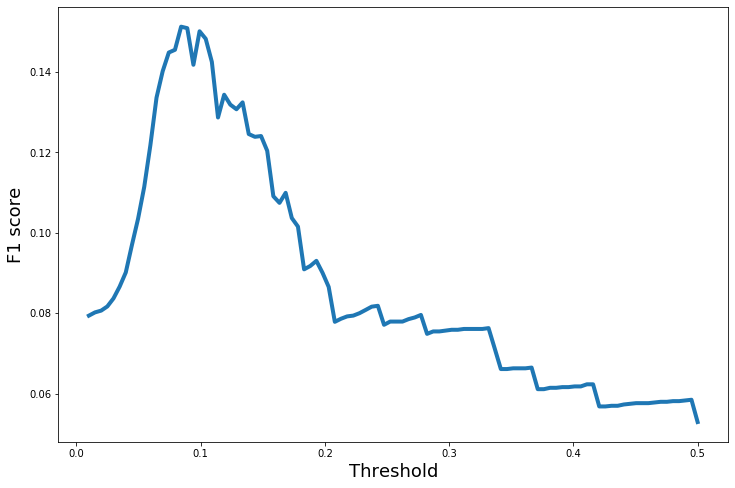

In [35]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
lda = LDA()

lda.fit(X_train, y_train)
pred_train_lda, pred_test_lda = BuildModel(lda, X_train, y_train, X_test,kf, ntrain, ntest, nclass, NFOLDS)

thresholds = np.linspace(0.01, 0.5, 100)
f1_sc_lda = np.array([f1_score(y_train,pred_train_lda[:,1] > thr) for thr in thresholds])
plt.figure(figsize=(12,8))
plt.plot(thresholds, f1_sc_lda, linewidth=4 )
plt.ylabel("F1 score", fontsize=18)
plt.xlabel("Threshold", fontsize=18)
best_thr_lda = thresholds[f1_sc_lda.argmax()]
print(f1_sc_lda.max())

show_accuracy(pred_train_lda[:,1],y_train, labels, best_thr_lda, nclass)

show_accuracy(pred_test_lda[:,1],y_test, labels, best_thr_lda, nclass)